<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/model_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"
model_path = '/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/models/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import Libs

In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import log_loss 
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV

# Load Data

In [5]:
cont_cat_lb = pd.read_pickle(data_path + 'data_cont_cat_lb.pkl')
cont_cat_oh = pd.read_pickle(data_path + 'data_cont_cat_oh.pkl')
bin_lb_cat_lb = pd.read_pickle(data_path + 'data_bin_lb_cat_lb.pkl')
bin_oh_cat_oh = pd.read_pickle(data_path + 'data_bin_oh_cat_oh.pkl')

print('cont_cat_lb: ', cont_cat_lb.shape)
print('cont_cat_oh: ', cont_cat_oh.shape)
print('bin_lb_cat_lb: ', bin_lb_cat_lb.shape)
print('bin_oh_cat_oh: ', bin_oh_cat_oh.shape)

cont_cat_lb:  (48813, 39)
cont_cat_oh:  (48813, 133)
bin_lb_cat_lb:  (48813, 39)
bin_oh_cat_oh:  (48813, 659)


# Utile Function

In [0]:

def evaluate_test_model(X, y, verbose = True):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  gbm = lgb.LGBMClassifier(n_estimators = 1000, silent = True)
  gbm.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds = 10, verbose = 0)

  y_train_hat = gbm.predict(X_train)
  y_test_hat = gbm.predict(X_test)

  tr_acc = accuracy_score(y_train, y_train_hat)
  tr_f1 = f1_score(y_train, y_train_hat)
  tr_auc = roc_auc_score(y_train, y_train_hat)

  test_acc = accuracy_score(y_test, y_test_hat)
  test_f1 = f1_score(y_test, y_test_hat)
  test_auc = roc_auc_score(y_test, y_test_hat)
  if verbose:
    print('------train-----------')
    print('accuracy_score: ', tr_acc)
    print('f1_score: ', tr_f1)
    print('roc_auc_score: ', tr_auc)
    print('------test-------------')
    print('accuracy_score: ', test_acc)
    print('f1_score: ', test_f1)
    print('roc_auc_score: ', test_auc)
  return [test_acc, test_f1, test_auc]

# Test data encoding

## Continuous Feature Vs Binnig

### Contiuous Featrue

In [56]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']
evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8889126712328768
f1_score:  0.7458551941238196
roc_auc_score:  0.8188570477903212
------test-------------
accuracy_score:  0.8732385622943696
f1_score:  0.7130410342889264
roc_auc_score:  0.7972260517006872


(0.8732385622943696, 0.7130410342889264, 0.7972260517006872)

### Binned Features



In [47]:
data = bin_lb_cat_lb
X, y = data.drop(columns = 'target'), data['target']
evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8801369863013698
f1_score:  0.724796405504072
roc_auc_score:  0.8056286689943598
------test-------------
accuracy_score:  0.866161772921969
f1_score:  0.6981237748529824
roc_auc_score:  0.7887243367238381


## Label encoding Vs One-hot encoding

### One-hot encoding

In [48]:
data = cont_cat_oh
X, y = data.drop(columns = 'target'), data['target']
evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8833170254403131
f1_score:  0.7321729365524987
roc_auc_score:  0.8101021552821349
------test-------------
accuracy_score:  0.8752871065863803
f1_score:  0.7194525904203324
roc_auc_score:  0.8019738286097503


### Label Encoding

In [49]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']
evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8889126712328768
f1_score:  0.7458551941238196
roc_auc_score:  0.8188570477903212
------test-------------
accuracy_score:  0.8732385622943696
f1_score:  0.7130410342889264
roc_auc_score:  0.7972260517006872


# Test reducing data dimensionality

In [98]:
data = bin_oh_cat_oh
print(data.shape)
max_pranciple_component = 100

(48813, 659)


In [99]:
result = []
for component_num in range(2, max_pranciple_component):
  pca = PCA(component_num)
  X, y = data.drop(columns = 'target'), data['target']
  projected_X = pca.fit_transform(X)
  print('Reducing data dimension to: ',  component_num)
  res = evaluate_test_model(projected_X, y, False)
  result.append(res)


Reducing data dimension to:  2
Reducing data dimension to:  3
Reducing data dimension to:  4
Reducing data dimension to:  5
Reducing data dimension to:  6
Reducing data dimension to:  7
Reducing data dimension to:  8
Reducing data dimension to:  9
Reducing data dimension to:  10
Reducing data dimension to:  11
Reducing data dimension to:  12
Reducing data dimension to:  13
Reducing data dimension to:  14
Reducing data dimension to:  15
Reducing data dimension to:  16
Reducing data dimension to:  17
Reducing data dimension to:  18
Reducing data dimension to:  19
Reducing data dimension to:  20
Reducing data dimension to:  21
Reducing data dimension to:  22
Reducing data dimension to:  23
Reducing data dimension to:  24
Reducing data dimension to:  25
Reducing data dimension to:  26
Reducing data dimension to:  27
Reducing data dimension to:  28
Reducing data dimension to:  29
Reducing data dimension to:  30
Reducing data dimension to:  31
Reducing data dimension to:  32
Reducing data di

In [0]:
result = np.array(result)

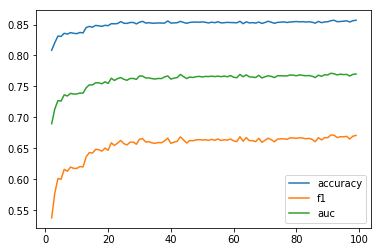

In [101]:
acc = result[:, 0]
f1 = result[:, 1]
auc = result[:, 2]
x = np.arange(2, max_pranciple_component)
plt.plot(x, acc, label = 'accuracy')
plt.plot(x, f1, label = 'f1')
plt.plot(x, auc, label = 'auc')
plt.legend()
plt.show()

In [106]:
result[90]

array([0.85691229, 0.67123092, 0.77042987])

# Feature Selection

In [0]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']

## Determine the optimal number of features

In [17]:
features_number = np.arange(1, data.shape[1])            
high_score = 0
feature_number = 0           
score_list =[]
for n in range(len(features_number)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    model = lgb.LGBMClassifier(n_estimators = 2000, silent = True)
    rfe = RFE(model, features_number[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train, eval_set = [(X_test_rfe, y_test)], early_stopping_rounds = 10, verbose = 0)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        feature_number = features_number[n]

print("Optimum number of features: %d" %feature_number)
print("Score with %d features: %f" % (feature_number, high_score))

Optimum number of features: 31
Score with 31 features: 0.874420


## Recursive Feature Elimination

In [18]:
cols = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model =lgb.LGBMClassifier(n_estimators = 2000, silent = True)
rfe = RFE(model, feature_number)             
X_rfe = rfe.fit_transform(X_train, y)
X_test_rfe = rfe.transform(X_test)
model.fit(X_rfe, y_train, eval_set = [(X_test_rfe, y_test)], early_stopping_rounds = 10, verbose = 0)             
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

Index(['age', 'workclass', 'final_weight', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'has_missing_values', 'com_workclass', 'com_marital_status',
       'com_native_country', 'age final_weight', 'age education_duration',
       'age hours_per_week', 'age capital_gain', 'age capital_loss',
       'final_weight education_duration', 'final_weight hours_per_week',
       'final_weight capital_gain', 'final_weight capital_loss',
       'education_duration hours_per_week', 'education_duration capital_gain',
       'education_duration capital_loss', 'hours_per_week capital_gain',
       'hours_per_week capital_loss'],
      dtype='object')


# Model Defintion

## Hyperparameter Tuning

In [0]:
data = cont_cat_lb[selected_features + ['target']]
X, y = data.drop(columns = 'target'), data['target']

In [21]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, log_loss

def objective(params):
  local_params = {
      'objective': 'binary',
      'metric': 'binary_logloss',
      'save_binary': True,
      'bagging_freq': 1,
      'bagging_seed': 2**7,
      'learning_rate': '{:.3f}'.format(params['learning_rate']),
      'num_leaves': int(params['num_leaves']),
      'min_data_in_leaf': int(params['min_data_in_leaf']),
      'max_depth': int(params['max_depth']),
      'bagging_fraction': '{:.3f}'.format(params['bagging_fraction']),
  }
  d_train = lgb.Dataset(X, label = y)
  cv_results = lgb.cv(local_params, d_train, num_boost_round = 2000, nfold = 5, 
                    verbose_eval = 0, early_stopping_rounds = 10)
  print('Best num_boost_round: {}'.format(len(cv_results['binary_logloss-mean'])))
  print("Best CV score {:.3f} params {}".format(cv_results['binary_logloss-mean'][-1], local_params))
  return cv_results['binary_logloss-mean'][-1]

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'num_leaves': hp.quniform('num_leaves', 7, 4095, 2),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 20, 500, 5),
    'max_depth': hp.quniform('max_depth', 2, 63, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, 1),
}

best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 100)

Best num_boost_round: 65
Best CV score 0.289 params {'objective': 'binary', 'metric': 'binary_logloss', 'save_binary': True, 'bagging_freq': 1, 'bagging_seed': 128, 'learning_rate': '0.141', 'num_leaves': 1364, 'min_data_in_leaf': 225, 'max_depth': 41, 'bagging_fraction': '0.727'}
Best num_boost_round: 31
Best CV score 0.299 params {'objective': 'binary', 'metric': 'binary_logloss', 'save_binary': True, 'bagging_freq': 1, 'bagging_seed': 128, 'learning_rate': '0.220', 'num_leaves': 3502, 'min_data_in_leaf': 310, 'max_depth': 59, 'bagging_fraction': '0.473'}
Best num_boost_round: 397
Best CV score 0.286 params {'objective': 'binary', 'metric': 'binary_logloss', 'save_binary': True, 'bagging_freq': 1, 'bagging_seed': 128, 'learning_rate': '0.035', 'num_leaves': 3798, 'min_data_in_leaf': 235, 'max_depth': 10, 'bagging_fraction': '0.622'}
Best num_boost_round: 26
Best CV score 0.289 params {'objective': 'binary', 'metric': 'binary_logloss', 'save_binary': True, 'bagging_freq': 1, 'bagging_

In [23]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'bagging_fraction': 0.9950862015751782, 'learning_rate': 0.04588724059954422, 'max_depth': 8.0, 'min_data_in_leaf': 20.0, 'num_leaves': 1980.0}


# Model Training

In [152]:
data = cont_cat_lb[selected_features + ['target']]
X, y = data.drop(columns = 'target'), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
print('---Train size----')
print(X_train.shape)
print(y_train.shape)
print('---Validation size----')
print(X_val.shape)
print(y_val.shape)
print('---Test size----')
print(X_test.shape)
print(y_test.shape)

---Train size----
(29287, 31)
(29287,)
---Validation size----
(9763, 31)
(9763,)
---Test size----
(9763, 31)
(9763,)


In [0]:
lgbm_params = {
      'objective': 'binary',
      'metric': 'binary_logloss',
      'save_binary': True,
      'bagging_freq': 1,
      'bagging_seed': 2**7,
      'learning_rate': 0.045,
      'num_leaves': 1980,
      'min_data_in_leaf': 20,
      'max_depth': 8,
      'bagging_fraction':  0.995,
}

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.415017	valid_1's binary_logloss: 0.417077
[20]	training's binary_logloss: 0.353682	valid_1's binary_logloss: 0.358493
[30]	training's binary_logloss: 0.319187	valid_1's binary_logloss: 0.326947
[40]	training's binary_logloss: 0.298164	valid_1's binary_logloss: 0.308413
[50]	training's binary_logloss: 0.284401	valid_1's binary_logloss: 0.29737
[60]	training's binary_logloss: 0.275351	valid_1's binary_logloss: 0.290665
[70]	training's binary_logloss: 0.268434	valid_1's binary_logloss: 0.286364
[80]	training's binary_logloss: 0.262969	valid_1's binary_logloss: 0.28305
[90]	training's binary_logloss: 0.258145	valid_1's binary_logloss: 0.280535
[100]	training's binary_logloss: 0.254296	valid_1's binary_logloss: 0.278826
[110]	training's binary_logloss: 0.250641	valid_1's binary_logloss: 0.277353
[120]	training's binary_logloss: 0.245992	valid_1's binary_logloss: 0.276167
[130]	training's binary_l

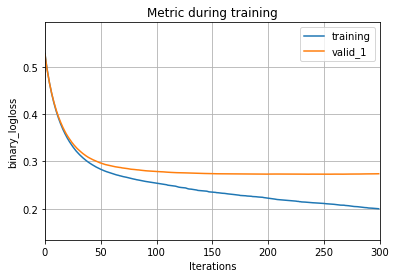

In [155]:
d_train = lgb.Dataset(X_train, y_train)
d_val = lgb.Dataset(X_val, y_val)
n_estimator = 2000
evals_result = {}
gbm_model = lgb.LGBMClassifier(
        n_estimators = 2000,
        **lgbm_params,
)
gbm_model.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_val, y_val)],
        verbose = 10, 
        early_stopping_rounds = 50)
ax = lgb.plot_metric(gbm_model.evals_result_)
plt.show()

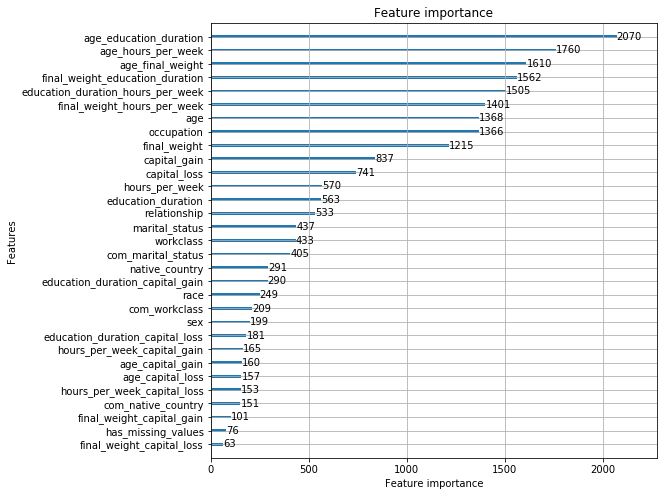

In [163]:
axis = lgb.plot_importance(gbm_model, max_num_features = 31, figsize = (8, 8))
plt.show()

# Model Evaluation

In [156]:
y_train_hat = gbm_model.predict(X_train)
y_test_hat = gbm_model.predict(X_test)

tr_acc = accuracy_score(y_train, y_train_hat)
tr_f1 = f1_score(y_train, y_train_hat)
tr_auc = roc_auc_score(y_train, y_train_hat)

test_acc = accuracy_score(y_test, y_test_hat)
test_f1 = f1_score(y_test, y_test_hat)
test_auc = roc_auc_score(y_test, y_test_hat)
print('------train-----------')
print('accuracy_score: ', tr_acc)
print('f1_score: ', tr_f1)
print('roc_auc_score: ', tr_auc)
print('------test-------------')
print('accuracy_score: ', test_acc)
print('f1_score: ', test_f1)
print('roc_auc_score: ', test_auc)

------train-----------
accuracy_score:  0.9062724075528391
f1_score:  0.7889922361442079
roc_auc_score:  0.8472672865450213
------test-------------
accuracy_score:  0.869200040971013
f1_score:  0.713484406551492
roc_auc_score:  0.8004399965931353


[[6896  479]
 [ 798 1590]]


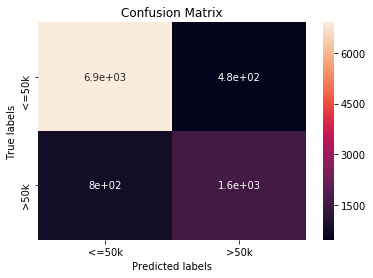

In [201]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = [0, 1]
cm = confusion_matrix(y_test, y_test_hat, labels)
print(cm)
ax=  plt.subplot()
sns.heatmap(cm, annot = True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['<=50k', '>50k']); 
ax.yaxis.set_ticklabels(['<=50k', '>50k']);

In [190]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7375
           1       0.77      0.67      0.71      2388

    accuracy                           0.87      9763
   macro avg       0.83      0.80      0.81      9763
weighted avg       0.87      0.87      0.87      9763



# Model Saving

In [189]:
gbm_model.booster_.save_model(model_path + 'lgbm_model.txt', num_iteration = gbm_model.booster_.best_iteration)